In [1]:
#For OceanParcels
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile, Field
import numpy as np
from netCDF4 import Dataset
import datetime
from IPython.display import display
import matplotlib
from matplotlib import pyplot as plt
import importlib
from datetime import timedelta
import pyproj

In [54]:
def simulate_parcels(source_url, output_filename, lat, lon, 
                     wind_drift_factor= 0.0, 
                     velocity_average= True, duration=23):
    
    filenames = {'U' : source_url, 'V': source_url}
    dimensions = {'lat': 'lat_v','lon': 'lon_u','time': 'ocean_time'}

    if velocity_average: 
        variables = {'U': 'ubar', 'V': 'vbar'}
    else:
        variables = {'U': 'u', 'V': 'v'}

    fieldset = FieldSet.from_netcdf(filenames, variables, dimensions,field_chunksize='auto', interp_method = 'cgrid_velocity')
    
    if wind_drift_factor:
        dimensions = {'lat':'lat_rho', 'lon':'lon_rho', 'time': 'ocean_time'}
        Uwind = Field.from_netcdf(source_url, ('U', 'Uwind'), dimensions, field_chunksize='auto', interp_method = 'cgrid_velocity')
        Vwind = Field.from_netcdf(source_url, ('V', 'Vwind'), dimensions, field_chunksize='auto', interp_method = 'cgrid_velocity')
        Uwind.set_scaling_factor(wind_drift_factor)
        Vwind.set_scaling_factor(wind_drift_factor)
        fieldset = FieldSet(U = fieldset.U+ Uwind,V = fieldset.V+ Vwind)

    pset = ParticleSet.from_list(fieldset = fieldset, pclass = JITParticle, lon=lon, lat=lat)
    output_file = pset.ParticleFile(name = output_filename, outputdt = timedelta(minutes=15))

    pset.execute(AdvectionRK4, runtime = timedelta(hours = duration), dt = timedelta(minutes=5), output_file = output_file)

    output_file.export()    

In [50]:
source_url = '/home/johanna/gpu-ocean/gpu_ocean/papers/MPI_SIR/netcdf_cache/NorFjords160/A10/norfjords_160m_his.nc4_2019071601-2019071700'

In [51]:
lat, lon = 68.5, 14.2

In [58]:
simulate_parcels(source_url, 'example.nc', lat, lon, duration = 20)
simulate_parcels(source_url, 'example_wind.nc', lat, lon, duration = 20, wind_drift_factor = 0.02)

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1001/ec3802cf91704e314d564448f49dc29d_0.so
INFO: Temporary output files are stored in out-JXHTOEOB.
INFO: You can use "parcels_convert_npydir_to_netcdf out-JXHTOEOB" to convert these to a NetCDF file during the run.
100% (72000.0 of 72000.0) |##############| Elapsed Time: 0:00:27 Time:  0:00:27
INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1001/23414d263fedfcbc1e22a15ba8f60d47_0.so
INFO: Temporary output files are stored in out-QZNPSWHT.
INFO: You can use "parcels_convert_npydir_to_netcdf out-QZNPSWHT" to convert these to a NetCDF file during the run.
100% (72000.0 of 72000.0) |##############| Elapsed Time: 0:00:59 Time:  0:00:59


(81,)


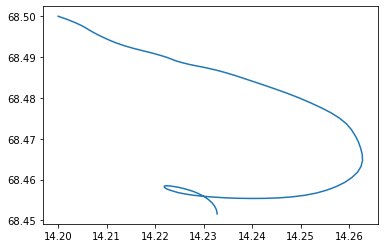

In [59]:
%matplotlib inline
pfile = Dataset('example_wind.nc')
t = pfile.variables['time'][0,:]
lon = np.ma.filled(pfile.variables['lon'], np.nan)
lat = np.ma.filled(pfile.variables['lat'], np.nan)
pfile.close()

print(lon[0].shape)
plt.plot(lon[0], lat[0])